In [1]:
%autosave 60

Autosaving every 60 seconds


In [66]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np


from sklearn import decomposition
from sklearn.metrics import accuracy_score, roc_auc_score,recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,  GridSearchCV
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler  
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix,classification_report

# стороняя библиотека для работы с несбалансированными датасетами
from imblearn.over_sampling import SMOTE, ADASYN

# настройки отображения графиков
# %config InlineBackend.figure_format = 'svg' 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
%matplotlib inline

# увеличим  размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 12,8


import itertools
# для воспроизводимости:
r_state = 11

In [100]:
data_path = './data/creditcard.csv'

In [101]:
df = pd.read_csv(data_path)

Проверим, что все считалось должным образом: 
 

In [102]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Сперва посмотрим на распределение меток у целевого класса:

In [103]:
df = df.sample(n=100000)

0    99830
1      170
Name: Class, dtype: int64


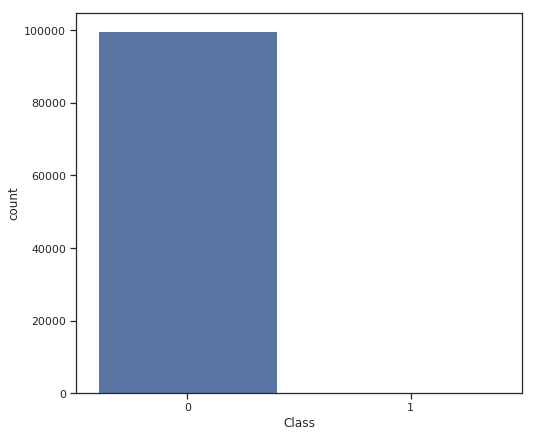

In [104]:
print(df['Class'].value_counts())
sns.countplot(df['Class']);

Отчетливо видно, что данные сильно несбалансированы. Для того, чтобы решить эту проблему, я буду использовать три подхода: алгоритмы ADASYN и SMOTE и обучение на сбалансированной подвыборке. Производить оценку моделей буду на тестовой части всей выборки.

Оценим, насколько мошеннические транзакции коррелируют со временем:

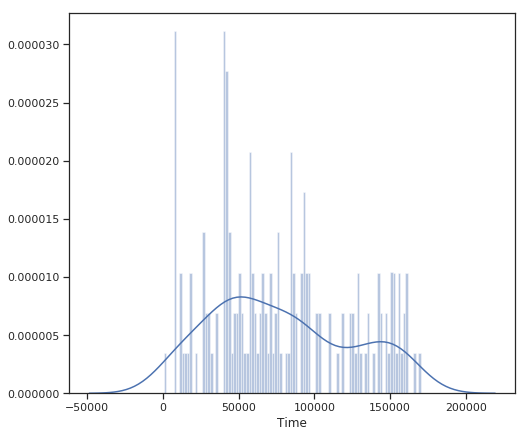

In [105]:
sns.distplot(df[df['Class']==1]['Time'],100);

Видим, что имеется два максимума, но на общем фоне они не сильно выделяются.

Посмотрим как пространство признаков изображается при двумерной проекции(на примере признаков 'V11', 'V12', 'V13', 'V14', 'V15') :

CPU times: user 16.3 s, sys: 14.9 s, total: 31.1 s
Wall time: 10.7 s


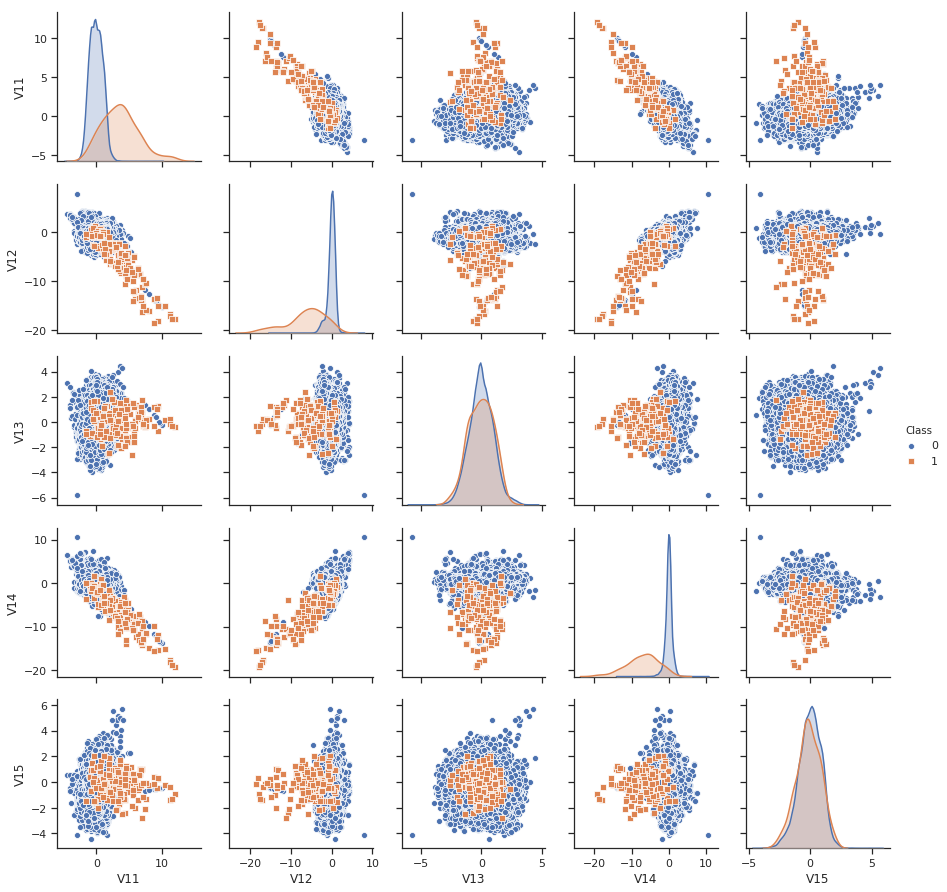

In [106]:
%%time

rcParams['figure.figsize'] = 12,12
sns_plot = sns.pairplot(df,vars=['V11', 'V12', 'V13', 'V14', 'V15'],hue="Class",markers=["o", "s"])
rcParams['figure.figsize'] = 8,7

In [107]:
# %%time
# tsne = TSNE(random_state=17)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df.drop(['Class'],axis=1))
# tsne_representation = tsne.fit_transform(X_scaled)
# plt.scatter(tsne_representation[:, 0], tsne_representation[:, 1], 
#             c=df['Class'].map({0: 'blue', 1: 'orange'}));

Для получения качественных оценок работы алгоритма, я буду сравнивать такие метрики как:
- **Recall score**

   Это оценка вида: 
   
   $$score = {tp \over tp + fn}$$
   
   tp - число предсказаний, когда модель верно обнаружила нужные транзакции.
   
   fn - число предсказаний, когда модель не распознала поддельный перевод.
   
   Чем ближе это значение к 1, тем меньше модель пропускает поддельных транзакций. Но, возможно, она будет помечать некоторые переводы как поддельные, хотя они таковыми не являются. Следующие метрики должны помочь проконтролировать этот аспект.
   
   
- **Precision score**

   Это оценка вида: 
   
   $$score = {tp \over tp + fp}$$
   
   Чем ближе к 1 это значение, тем меньше законных транзакций помечаются как поддельные

   
- **Accuracy**

   Доля верных ответов, будем его тоже учитывать.
   
   
- **ROC AUC score**

   Площадь, ограниченная ROC-кривой и осью доли ложных положительных классификаций.
   Эта метрика позволяет судить о качестве бинарной классификации и в совокупности с Recall score  и Precision score должна дать нам наглядное представление о работе классификатора.

Я буду использовать алгоритм ADASYN(Adaptive Synthetic Sampling) и SMOTE (Synthetic Minority Over-sampling Technique) разница между ними в том, что SMOTE создает больше примеров внутри кластера, а ADASYN создает больше синтетических примеров на границе. В дальнейшем, я сравню эти два алгоритма

В случае, когда данные генерируются ADASYN, модель становится более "подозрительной", поскольку будет лучше опознавать мошеннические транзакции на границе двух кластеров, ведь ADASYN может расширить границы имеющего кластера. Хотя это и может привести к ошибкам рода False Positive, мне кажется, что такой подход будет надежнее и более подходит для предотвращения мошенничества.

In [108]:
def plot_confusion_matrix(cm, classes=[0,1],title='Confusion matrix',cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [109]:
# Соединим строки поддельных с переводов исходного датасета с таким же количеством неподдельных
def create_balanced_data_from_initial(data):
    
    fraud = data[(data['Class']==1)]
    not_fraud = data[(data['Class']==0)]
    
    n_fraud = len(fraud)//2
    
    X_original_unb = pd.concat([fraud[n_fraud:].drop(['Class'], axis=1),not_fraud[n_fraud:].drop(['Class'], axis=1)])
    
    y_original_unb = pd.concat([fraud[n_fraud:]['Class'],not_fraud[n_fraud:]['Class']])
    
    X_original_b = pd.concat([fraud[:n_fraud-1].drop(['Class'], axis=1),not_fraud[:n_fraud-1].drop(['Class'], axis=1)])
    
    y_original_b = pd.concat([fraud[:n_fraud-1]['Class'],not_fraud[:n_fraud-1]['Class']])
    

    return X_original_unb,y_original_unb,X_original_b,y_original_b
    

In [110]:
# Применение алгоритма ADASYN
def create_balanced_data_adasyn(x,y):
    sm = ADASYN(random_state=12, ratio = 'minority')
    X,Y = sm.fit_sample(x, y)
    X = pd.DataFrame(X,columns = ['Time','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'] )
    Y = pd.DataFrame(Y,columns = ['Class'])
    return X,Y

In [111]:
def create_balanced_data_smote(x,y):
    sm = SMOTE(random_state=12, ratio = 'minority')
    X,Y = sm.fit_sample(x, y)
    X = pd.DataFrame(X,columns = ['Time','V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'] )
    Y = pd.DataFrame(Y,columns = ['Class'])
    return X,Y

In [112]:
# Оценка модели на указанных датасетах
def estimate_model(clf, X_original_b,y_original_b,  X_test, y_test):

    print("ROC AUC score: "+ str(roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])))
    print(classification_report(y_test,clf.predict(X_test)))

In [113]:
X_original_unb,y_original_unb,X_original_b,y_original_b = create_balanced_data_from_initial(df)

Далее, при генерации данных ADASYN и SMOTE, необходимо сначала отделить тестовую и проверочную выборки, а затем для тренировочной сгенерировать новые данные. Тк в противном случае, если сначала создать новых данных, а потом разделить выборку, то синтетические данные попадут в проверочный сет.

In [114]:
# Разделим на тестовую и тренировочную
X_train, X_test, y_train, y_test = train_test_split(X_original_unb,y_original_unb, test_size=0.3)

Будем сравнивать результаты на разных датасетах и выберем наилучшую методику обучения

In [115]:
datasets = {'NOT SYNTHETIC UNBALANCED DATA':(X_train,y_train),
            'NOT SYNTHETIC BALANCED DATA':(X_original_b,y_original_b),
            'ADASYN': create_balanced_data_adasyn(X_train, y_train),
            'SMOTE': create_balanced_data_smote(X_train, y_train)}

StratifiedKFold - сохраняет процент образцов в тестовом и тренировочных сетах, поэтому такому кросс-валиждатору можно доверять

In [116]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=r_state)

Рассмотрим несколько моделей и выберем наилучшую.

## Случайный лес

In [ ]:
%%time
parameters = {"max_depth": [3,5, None],
              "n_estimators":[15,16,20],
              "max_features": [6,7,8],
              'n_jobs':[-1]}

rfc = RandomForestClassifier()

gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=0,scoring='recall')

fig = plt.figure(figsize=(16,8))
j=1

for key in sorted(datasets):
    print('\n###############################\n')
    
    gcv.fit(datasets[key][0],datasets[key][1])
    
    best_rfc= gcv.best_estimator_   
    
    print(key,gcv.best_params_ , gcv.best_score_)
    
    estimate_model(gcv.best_estimator_ , X_original_b,y_original_b, X_test, y_test)
    
    conf_matrix = confusion_matrix(y_test,gcv.best_estimator_.predict(X_test))
   
    fig.add_subplot(2,3,j)
    j += 1

    plot_confusion_matrix(conf_matrix, title=key)
plt.show()    
    


###############################



## Метод ближайших соседей

In [ ]:
%%time
parameters = {'n_neighbors': range(10,30,10),'n_jobs':[-1]}



knn = KNeighborsClassifier()

gcv = GridSearchCV(knn, parameters, n_jobs=-1, cv=skf, verbose=0,scoring='recall')

fig = plt.figure(figsize=(16,8))
j=1

for key in sorted(datasets):
    print('\n###############################\n')
    
    gcv.fit(datasets[key][0],datasets[key][1])
    
    best_knn = gcv.best_estimator_   
    
    print(key,gcv.best_params_ , gcv.best_score_)
    
    estimate_model(gcv.best_estimator_ , X_original_b,y_original_b, X_test, y_test)
    
    conf_matrix = confusion_matrix(y_test,gcv.best_estimator_.predict(X_test))
   
    fig.add_subplot(2,3,j)
    j += 1

    plot_confusion_matrix(conf_matrix, title=key)
plt.show()    


## Логистическая регрессия

In [ ]:
%%time
logit = LogisticRegression(n_jobs=-1)       

parameters = {'C': [5,10,20,30],'penalty':['l1', 'l2']}



gcv = GridSearchCV(logit, parameters, n_jobs=-1, cv=skf, verbose=0,scoring='recall')

fig = plt.figure(figsize=(16,8))
j=1

for key in sorted(datasets):
    print('\n###############################\n')
    
    gcv.fit(datasets[key][0],datasets[key][1])
    
    best_logit = gcv.best_estimator_   
    
    print(key,gcv.best_params_ , gcv.best_score_)
    
    estimate_model(gcv.best_estimator_ , X_original_b,y_original_b, X_test, y_test)
    
    conf_matrix = confusion_matrix(y_test,gcv.best_estimator_.predict(X_test))
   
    fig.add_subplot(2,3,j)
    j += 1

    plot_confusion_matrix(conf_matrix, title=key)
plt.show()    


## Нейросеть



Поскольку перед нами не стоит задача распознавания изображений, у нас не так много данных и они не имею слишком большой размерности, то воспользуемся встроенной в SKlearn нейросетью - MultiLayerClassifier

In [ ]:
%%time

scaler = RobustScaler()
for key in sorted(datasets):    
    scaler.fit_transform(datasets[key][0])
    scaler.fit_transform(datasets[key][0])

mlp = MLPClassifier(random_state=r_state)
parameters = {'activation':['logistic'], 'alpha':[1e-5],'hidden_layer_sizes':[(10,),(10,30,10,),(40,100,)],'learning_rate':['adaptive']}



gcv = GridSearchCV(mlp, parameters, n_jobs=-1, cv=skf, verbose=0,scoring='recall')

fig = plt.figure(figsize=(16,8))
j=1

for key in sorted(datasets):
    print('\n###############################\n')
    
    gcv.fit(datasets[key][0],datasets[key][1])
    
    best_mlp = gcv.best_estimator_   
    
    print(key,gcv.best_params_ , gcv.best_score_)
    
    estimate_model(gcv.best_estimator_ , scaler.transform(X_original_b),y_original_b, scaler.transform(X_test),y_test)
    
    conf_matrix = confusion_matrix(y_test,gcv.best_estimator_.predict(X_test))
   
    fig.add_subplot(2,3,j)
    j += 1

    plot_confusion_matrix(conf_matrix, title=key)
plt.show()    
